# Importing the data
### setting comprehensible col names and right types

In [1]:
# Importing all the necessary packages
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL
from pmdarima import auto_arima
from pmdarima.pipeline import Pipeline
from pmdarima.preprocessing import FourierFeaturizer
from prophet import Prophet


In [2]:
# Mix of different sources, mostly ESO
balancing_df = pd.read_csv("balancing_data.csv")
# Demand data only for GB
GB_demand_df = pd.read_csv("demand_load_data.csv")
# Generation data only for GB
GB_generation_df = pd.read_csv("generation_data.csv")
# the price dataframe only concerns EPEX (only prices from there)
EPEX_price_df = pd.read_csv("price_data.csv")

In [3]:
def rename_balancing_columns(df):
    # Define a dictionary for concise renaming
    rename_map = {
        'GMT Time': 'GMT Time',
        'System Price (ESO Outturn) - GB (£/MWh)': 'System_Price',
        'NIV Outturn (+ve long) - GB (MW)': 'NIV_Outturn',
        'BM Bid Acceptances (total) - GB (MW)': 'BM_Bid_Acceptances',
        'BM Offer Acceptances (total) - GB (MW)': 'BM_Offer_Acceptances',
        'Total BSAD Volume - Turn Up - GB (MW)': 'BSAD_Turn_Up',
        'Total BSAD Volume - Turn Down - GB (MW)': 'BSAD_Turn_Down',
        'Total BSAD Volume - Total - GB (MW)': 'BSAD_Total',
        'Intraday Volume (EPEX Outturn, APX, MID) - GB (MWh)': 'EPEX_Intraday_Volume'
    }
    
    # Apply the renaming map
    df = df.rename(columns=rename_map)
    for column in df.columns:
        if column != 'GMT Time':  # Skip the 'GMT Time' column
            df[column] = pd.to_numeric(df[column], errors='coerce')

    return df

# Apply the function to rename columns in balancing_df
balancing_df = rename_balancing_columns(balancing_df)
print(balancing_df.columns, "rows:", len(balancing_df))


Index(['GMT Time', 'System_Price', 'NIV_Outturn', 'BM_Bid_Acceptances',
       'BM_Offer_Acceptances', 'BSAD_Turn_Up', 'BSAD_Turn_Down', 'BSAD_Total',
       'EPEX_Intraday_Volume'],
      dtype='object') rows: 118320


In [4]:
def rename_demand_columns(df):
    # Define a dictionary for concise renaming
    rename_map = {
        'GMT Time': 'GMT Time',
        'Loss of Load Probability - Latest - GB ()': 'Loss_of_Load_Prob',
        'Actual Total Load - GB (MW)': 'Total_Load',
        'Demand Outturn (ITSDO) - GB (MW)': 'Demand_Outturn'
    }
    
    # Apply the renaming map
    df = df.rename(columns=rename_map)
    for column in df.columns:
        if column != 'GMT Time':  # Skip the 'GMT Time' column
            df[column] = pd.to_numeric(df[column], errors='coerce')

    return df

# Apply the function to rename columns in demand_df
GB_demand_df = rename_demand_columns(GB_demand_df)
print(GB_demand_df.columns, "rows:", len(GB_demand_df))

Index(['GMT Time', 'Loss_of_Load_Prob', 'Total_Load', 'Demand_Outturn'], dtype='object') rows: 118320


In [5]:
def rename_columns(df):
    # Define a function to clean each column name
    def clean_column_name(col):
        # Extract the generation type using regex
        match = re.search(r'Actual Aggregated Generation By Type - (.+?) - GB', col)
        if match:
            # Replace spaces with underscores for readability
            return match.group(1).replace(" ", "_")
        return col  # Return the column as is if no match is found

    # Rename columns using the clean_column_name function
    df.columns = [clean_column_name(col) for col in df.columns]
    for column in df.columns:
        if column != 'GMT Time':  # Skip the 'GMT Time' column
            df[column] = pd.to_numeric(df[column], errors='coerce')

    return df

# Apply the function to rename columns in generation_df
GB_generation_df = rename_columns(GB_generation_df)
print(GB_generation_df.columns, "rows:", len(GB_generation_df))


Index(['GMT Time', 'Biomass', 'Fossil_Gas', 'Fossil_Hard_Coal', 'Fossil_Oil',
       'Hydro_Pumped_Storage', 'Hydro_Run-of-River_and_Poundage', 'Nuclear',
       'Solar', 'Wind_Onshore', 'Wind_Offshore'],
      dtype='object') rows: 118320


In [6]:
def rename_epex_columns(df):
    # Define a dictionary for manual renaming based on your desired column names
    rename_map = {
        'GMT Time': 'GMT Time',
        'Day Ahead Price (EPEX half-hourly, local) - GB (LC/MWh)': 'Day_Ahead_Price',
        'Intraday Price (EPEX Outturn, APX, MID) - GB (£/MWh)': 'Intraday_Price'
    }
    
    # Rename columns using the dictionary
    df = df.rename(columns=rename_map)
    for column in df.columns:
        if column != 'GMT Time':  # Skip the 'GMT Time' column
            df[column] = pd.to_numeric(df[column], errors='coerce')

    return df

# Apply the function to rename columns in EPEX_price_df
EPEX_price_df = rename_epex_columns(EPEX_price_df)
print(EPEX_price_df.columns, "rows:", len(EPEX_price_df))

Index(['GMT Time', 'Day_Ahead_Price', 'Intraday_Price'], dtype='object') rows: 118320


In [7]:
# Set 'GMT Time' as index for each dataframe
balancing_df.set_index('GMT Time', inplace=True)
GB_demand_df.set_index('GMT Time', inplace=True)
GB_generation_df.set_index('GMT Time', inplace=True)
EPEX_price_df.set_index('GMT Time', inplace=True)

# Merge using index
merged_df = balancing_df.join([GB_demand_df, GB_generation_df, EPEX_price_df], how='inner')
# We put back the datetime column into the merged DF and rename it for practicality
merged_df.reset_index(inplace=True)
merged_df.rename(columns={'GMT Time': 'Datetime'}, inplace=True)
print(merged_df.columns, "rows", len(merged_df))

Index(['Datetime', 'System_Price', 'NIV_Outturn', 'BM_Bid_Acceptances',
       'BM_Offer_Acceptances', 'BSAD_Turn_Up', 'BSAD_Turn_Down', 'BSAD_Total',
       'EPEX_Intraday_Volume', 'Loss_of_Load_Prob', 'Total_Load',
       'Demand_Outturn', 'Biomass', 'Fossil_Gas', 'Fossil_Hard_Coal',
       'Fossil_Oil', 'Hydro_Pumped_Storage', 'Hydro_Run-of-River_and_Poundage',
       'Nuclear', 'Solar', 'Wind_Onshore', 'Wind_Offshore', 'Day_Ahead_Price',
       'Intraday_Price'],
      dtype='object') rows 118320


# Seasonality analysis

### Visual Inspection

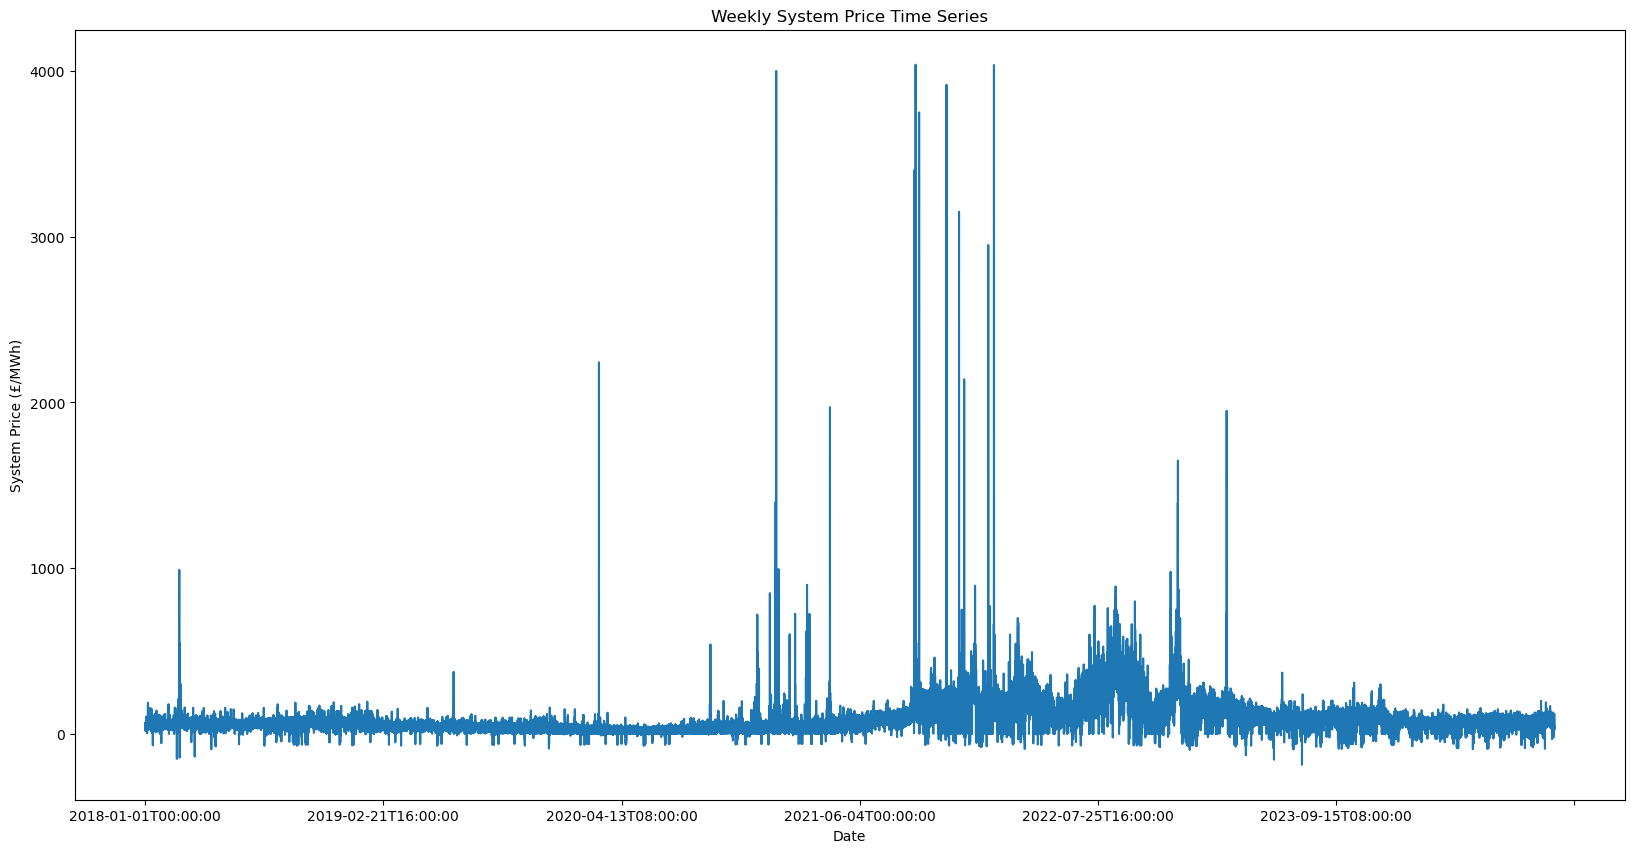

In [13]:
# Plotting the System Price over a shorter period to check daily patterns
balancing_df['System_Price'].plot(figsize=(20, 10))
plt.title('Weekly System Price Time Series')
plt.xlabel('Date')
plt.ylabel('System Price (£/MWh)')
plt.show()

### ACF and PACF

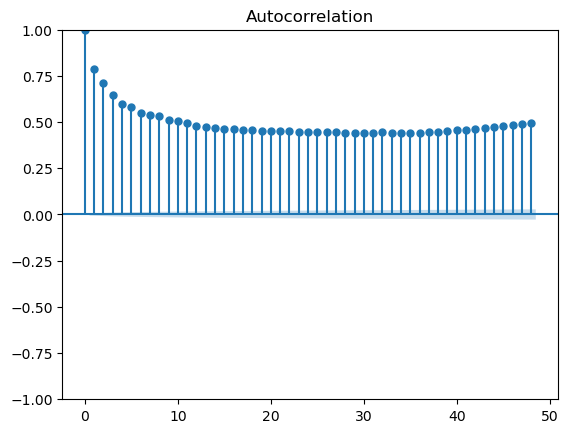

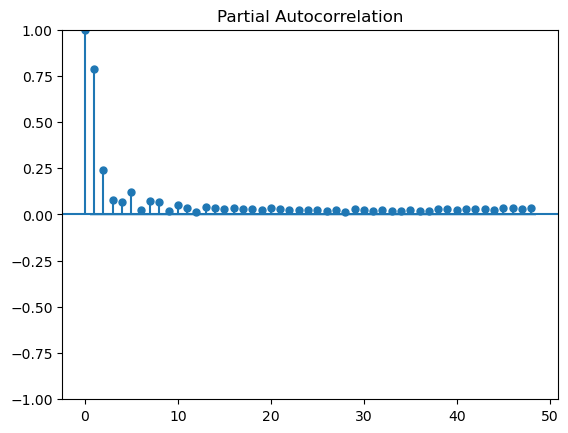

In [9]:
# Plot ACF
plot_acf(balancing_df['System_Price'].dropna(), lags=48)  # 48 lags cover two days if data is half-hourly
plt.show()

# Plot PACF
plot_pacf(balancing_df['System_Price'].dropna(), lags=48)
plt.show()

### Seasonal Decomposition

17:50:26 - cmdstanpy - INFO - Chain [1] start processing
17:53:48 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\ruben\anaconda3\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  dates = pd.date_range(


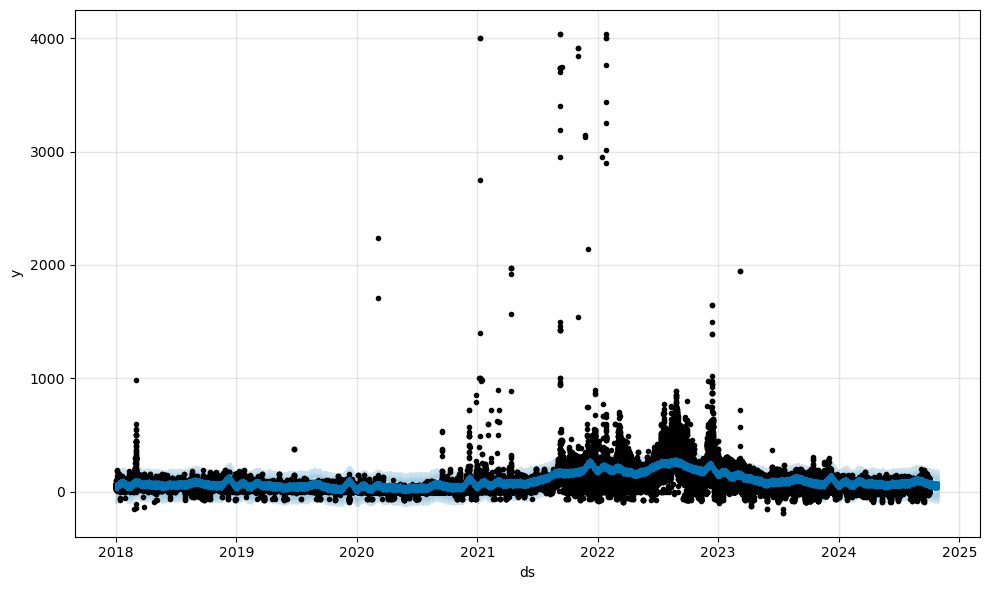

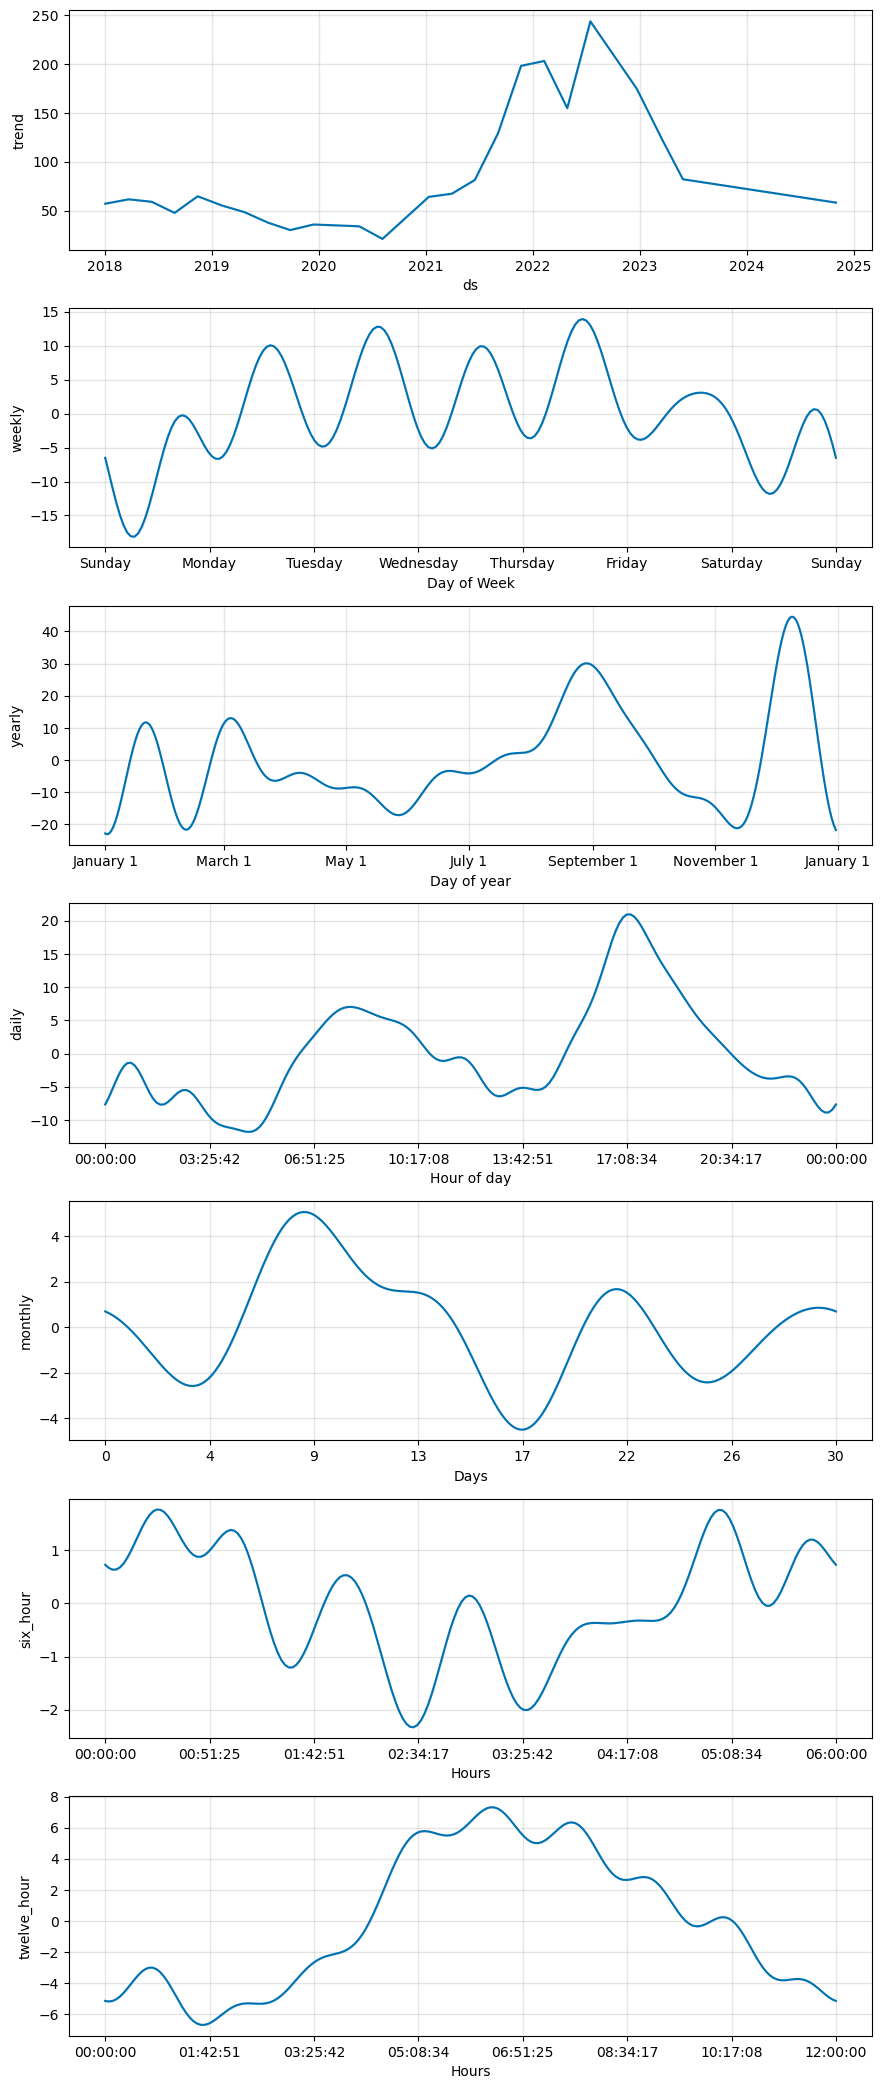

In [10]:
# Use Prophet to model multiple seasonalities
prophet_balancing_df = balancing_df.reset_index().rename(columns={'GMT Time': 'ds', 'System_Price': 'y'})
model = Prophet()
model.add_seasonality(name='six_hour', period=0.25, fourier_order=10)
model.add_seasonality(name='twelve_hour', period=0.5, fourier_order=10)
model.add_seasonality(name='daily', period=1, fourier_order=15)
model.add_seasonality(name='weekly', period=7, fourier_order=10)
model.add_seasonality(name='monthly', period=30.4375, fourier_order=5)
model.add_seasonality(name='yearly', period=365.25, fourier_order=10)

model.fit(prophet_balancing_df)

future = model.make_future_dataframe(periods=48 * 30, freq='30T')
forecast = model.predict(future)

# Plot the forecast
model.plot(forecast)
plt.show()

# Plot the components
model.plot_components(forecast)
plt.show()

### Fourier Transform for Frequency Analysis
#### Find out which are the important cycles

Frequency: 0.000000 cycles per day, Amplitude: 10362782.50 (DC Component)
Frequency: 0.000406 cycles per day, Amplitude: 3964030.64, Period: once every 2464.06 days
Frequency: 0.000812 cycles per day, Amplitude: 2477412.51, Period: once every 1232.03 days
Frequency: 0.001218 cycles per day, Amplitude: 945540.86, Period: once every 821.35 days
Frequency: 0.001623 cycles per day, Amplitude: 415237.81, Period: once every 616.02 days
Frequency: 0.002841 cycles per day, Amplitude: 816276.34, Period: once every 352.01 days
Frequency: 0.003247 cycles per day, Amplitude: 427995.10, Period: once every 308.01 days
Frequency: 0.004464 cycles per day, Amplitude: 448129.18, Period: once every 224.01 days
Frequency: 0.004870 cycles per day, Amplitude: 416949.74, Period: once every 205.34 days
Frequency: 0.005276 cycles per day, Amplitude: 451802.13, Period: once every 189.54 days
Frequency: 0.005682 cycles per day, Amplitude: 471972.83, Period: once every 176.00 days
Frequency: 0.006088 cycles per d

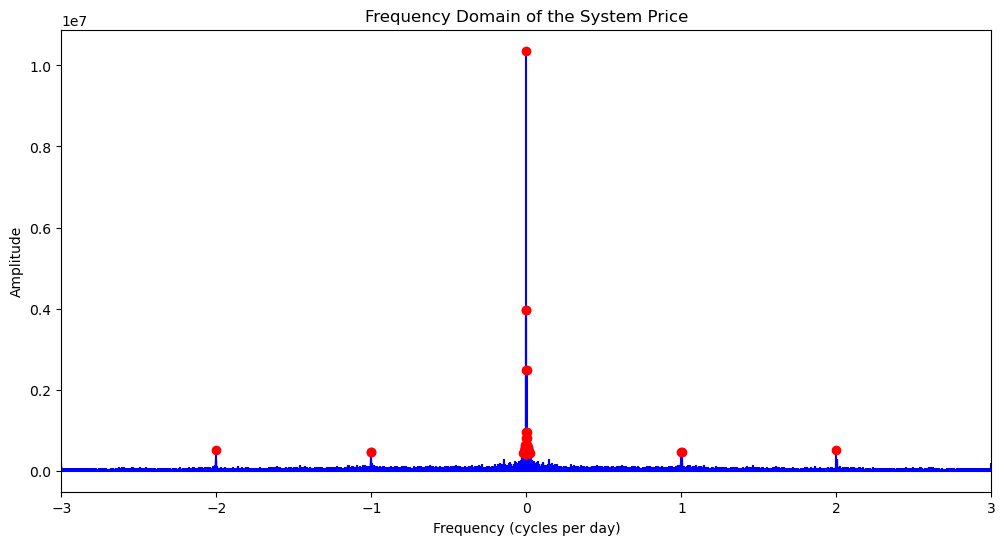

In [16]:
# Compute fast Fourier transform
price_fft = np.fft.fft(balancing_df['System_Price'].dropna())

# Get frequencies corresponding to FFT coefficients
# d is the interval in terms of days if data is half-hourly, thus frequencies are in cycles per day
freqs = np.fft.fftfreq(len(price_fft), d=1/48)

# Calculate amplitudes
amplitudes = np.abs(price_fft)
threshold = 0.04 * np.max(amplitudes)  # Setting a 4% threshold of the maximum amplitude for significance

# Find frequencies with significant amplitudes
significant_freqs = freqs[np.where(amplitudes > threshold)]
significant_amplitudes = amplitudes[np.where(amplitudes > threshold)]

counter = 0
# Print significant frequencies and their amplitudes in a human-readable format
for freq, amp in zip(significant_freqs, significant_amplitudes):
    if freq != 0:
        period_in_days = 1 / freq
        print(f"Frequency: {freq:.6f} cycles per day, Amplitude: {amp:.2f}, Period: once every {period_in_days:.2f} days")
    else:
        print(f"Frequency: {freq:.6f} cycles per day, Amplitude: {amp:.2f} (DC Component)")
    counter += 1
print("There are", counter, "cycles that fit the criteria")

# Plotting the frequency spectrum
plt.figure(figsize=(12, 6))
plt.stem(freqs, amplitudes, 'b', markerfmt=" ", basefmt="-b")
plt.title('Frequency Domain of the System Price')
plt.xlabel('Frequency (cycles per day)')  # Corrected to cycles per day
plt.ylabel('Amplitude')

# Highlight significant frequencies on the plot
for freq, amp in zip(significant_freqs, significant_amplitudes):
    plt.plot(freq, amp, 'ro')  # Mark significant points in red

# Restrict the x-axis to show only -3 to +3
plt.xlim(-3, 3)

plt.show()